# Ungraded Lab: Using more sophisticated images with Convolutional Neural Networks

In Course 1 of this Specialization, you saw how to use a Convolutional Neural Networks (CNNs)  to make recognition of computer generated images of horses and humans more efficient. In this lesson, you'll take that to the next level: building a model to classify real images of cats and dogs. Like the horses and humans dataset, real-world images also come in different shapes, aspect ratios, etc. and you will need to consider these when preparing your data.

In this lab, you will review how to build CNNs, preprocess the data with the `tf.data` API, and examine your results. You'll follow these steps:

1.   Explore the example data of `Dogs vs. Cats`
2.   Build and train a neural network to classify between the two pets
3.   Evaluate the training and validation accuracy

You will build upon your results here in the next labs so you can improve it, particularly in avoiding overfitting. Let's begin!

## Inspect the Dataset

You will start by looking at the dataset. It consists of of 2,000 JPG pictures of cats and dogs. It is a subset of the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. You will only use 2,000 of the full dataset to decrease training time for educational purposes.

First import the necessary libraries.

In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

The contents are already saved to the base directory `./cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (you can ignore `vectorize.py` in the output in the next cell).

If you recall, the **training set** is the data that is used to tell the neural network model that 'this is what a cat looks like' and 'this is what a dog looks like'. The **validation set** is images of cats and dogs that the neural network will not see as part of the training. You can use this to test how well or how badly it does in evaluating if an image contains a cat or a dog. (See the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) if you want a refresher on training, validation, and test sets.)

These subdirectories in turn each contain `cats` and `dogs` subdirectories. You can assign each of these directories to a variable so you can use it later.

In [2]:
BASE_DIR = './cats_and_dogs_filtered'

train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

# Directory with training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


print(f"Contents of base directory: {os.listdir(BASE_DIR)}")

print(f"\nContents of train directory: {train_dir}")

print(f"\nContents of validation directory: {validation_dir}")

Contents of base directory: ['vectorize.py', 'train', 'validation']

Contents of train directory: ./cats_and_dogs_filtered/train

Contents of validation directory: ./cats_and_dogs_filtered/validation


Now see what the filenames look like in the `cats` and `dogs` `train` directories. The file naming conventions are the same in the `validation` directory:

In [3]:
train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

print(f"5 files in cats subdir: {train_cat_fnames[:5]}")
print(f"5 files in dogs subdir: {train_dog_fnames[:5]}")

5 files in cats subdir: ['cat.227.jpg', 'cat.308.jpg', 'cat.146.jpg', 'cat.623.jpg', 'cat.74.jpg']
5 files in dogs subdir: ['dog.702.jpg', 'dog.540.jpg', 'dog.90.jpg', 'dog.621.jpg', 'dog.18.jpg']


Check the total number of cat and dog images in the `train` and `validation` directories:

In [4]:
print(f'total training cat images: {len(os.listdir(train_cats_dir))}')
print(f'total training dog images: {len(os.listdir(train_dogs_dir))}')

print(f'total validation cat images: {len(os.listdir(validation_cats_dir))}')
print(f'total validation dog images: {len(os.listdir(validation_dogs_dir))}')

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


For both cats and dogs, you have 1,000 training images and 500 validation images.

Now take a look at a few pictures to get a better sense of what the cat and dog datasets look like. You can re-run the cell to see a fresh batch each time:

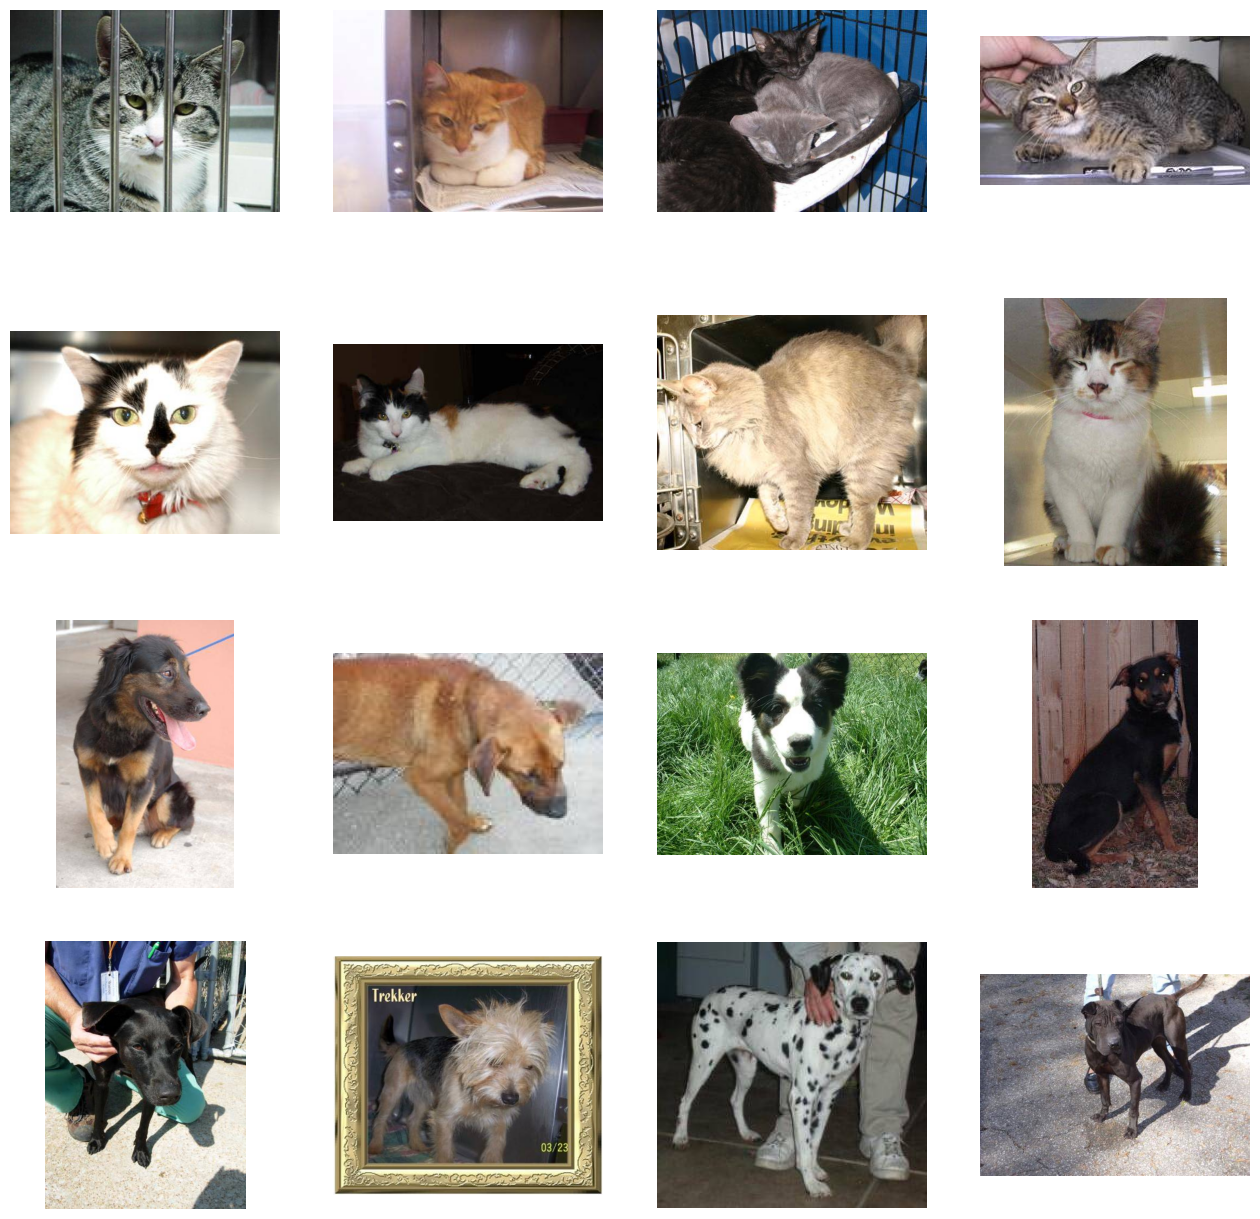

In [5]:
# Parameters for your graph; you will output images in a 4x4 configuration
nrows = 4
ncols = 4

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in random.sample(train_cat_fnames, k=8)]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in random.sample(train_dog_fnames, k=8)]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

It may not be obvious from looking at the images in this grid but an important note here is that these images come in all shapes and sizes (just like the 'horses or humans' dataset). So before training a neural network with them, you'll need to tweak the images. You'll see that in the next sections.

## Building a Small Model from Scratch

To train a neural network to handle the images, you'll need them to be in a uniform size. You will choose 150x150 pixels for this, and you'll see the code that preprocesses the images to that shape shortly.

You can define the model by importing Tensorflow and using the Keras API. Here is the entire code first then the discussion comes after. This is very similar to the models you built in Course 1.


In [6]:
model = tf.keras.models.Sequential([
    # Rescale the image. Note the input shape is the desired size of the image: 150x150 with 3 bytes for color
    tf.keras.Input(shape=(150, 150, 3)),
    tf.keras.layers.Rescaling(1./255),
    # Convolution and Pooling layers
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for one class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')
])

You defined a [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model as before. The first layer is the [Rescaling](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer. Note the `input_shape` parameter. Here is where you put the `150x150` size and `3` for the color depth because you have colored images.

Images that go into neural networks are usually normalized to make them more amenable to processing by the network. In this case, your model will rescale the pixel values from being in the `[0, 255]` range into the `[0, 1]` range. If you've taken Course 1 of this Specialization, you might remember rescaling as part of the data pipeline (i.e. with a `.map` method of the `tf.data.Dataset`). Here, you used a different approach where this process happens within the model itself. This is usually the preferred way so you don't need to remember rescaling your images. The model does it for you.

Next, you added some convolutional and pooling layers to extract features. Then, you will flatten the result to feed into the densely connected layers

Because you are facing a two-class classification problem, i.e. a *binary classification problem*, you will end the network with a [*sigmoid* activation](https://wikipedia.org/wiki/Sigmoid_function). The output will be a single scalar between `0` and `1`, encoding the probability that the current image is class `1` (as opposed to class `0`).

You can review the architecture of the network with the `model.summary()` method:

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18496)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,470,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,494,561 (36.22 MB)

 Trainable params: 9,494,561 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

The `output_shape` column shows how the size of your feature map evolves in each successive layer. The convolution operation removes the outermost pixels from the original dimensions, and each pooling layer halves it.

Next, you'll configure the specifications for model training. You will train the model with the `binary_crossentropy` loss, because it's a binary classification problem and your final activation is a sigmoid. You will use the `rmsprop` optimizer with an initial learning rate of `0.001`. The [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) automates learning-rate tuning for you. Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.

During training, you will want to monitor classification accuracy.

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy']
    )

### Data Preprocessing

Next step is to set up the `tf.data.Dataset` objects that will read pictures in the source folders and feed them (with their labels) to the model. You'll have one for the training images and another for the validation images. These will yield batches of images of size 150x150 and their labels (binary).



In [9]:
# Instantiate the Dataset object for the training set
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )

# Instantiate the Dataset object for the validation set
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(150, 150),
    batch_size=20,
    label_mode='binary'
    )

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


You will then chain a few more methods to optimize the datasets for training and validation. As a refresher:
* [cache()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stores elements in memory as you use them so it will be faster to retrieve if you need them again
* [shuffle()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle), as the name suggests, shuffles the dataset randomly. A `buffer_size` of 1000 means it will first select a sample from the first 1,000 elements, then keep filling this buffer until all elements have been selected.
* [prefetch()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) gets elements while the model is training so it's faster to feed in new data when the current training step is finished. A `buffer_size` set to `tf.data.AUTOTUNE` dynamically sets the number of elements to prefetch during runtime.

In [10]:
SHUFFLE_BUFFER_SIZE = 1000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE

train_dataset_final = train_dataset.cache().shuffle(SHUFFLE_BUFFER_SIZE).prefetch(PREFETCH_BUFFER_SIZE)
validation_dataset_final = validation_dataset.cache().prefetch(PREFETCH_BUFFER_SIZE)

### Training
You will now train on all 2,000 images available, for 15 epochs, and monitor the accuracy as well on the 1,000 images in the validation set.

Do note the values per epoch. You'll see 4 -- Loss, Accuracy, Validation Loss and Validation Accuracy.

The `loss` and `accuracy` are great indicators of progress in training. `loss` measures the current model prediction against the known labels, calculating the result. `accuracy`, on the other hand, is the portion of correct guesses.


In [11]:
history = model.fit(
    train_dataset_final,
    epochs=15,
    validation_data=validation_dataset_final,
    verbose=2
    )

Epoch 1/15


I0000 00:00:1741003654.394090     229 service.cc:145] XLA service 0x79d6b4004590 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741003654.394208     229 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1741003656.289078     229 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 - 6s - 55ms/step - accuracy: 0.5390 - loss: 0.7450 - val_accuracy: 0.5730 - val_loss: 0.6801
Epoch 2/15
100/100 - 1s - 6ms/step - accuracy: 0.6180 - loss: 0.6602 - val_accuracy: 0.6820 - val_loss: 0.6221
Epoch 3/15
100/100 - 0s - 5ms/step - accuracy: 0.6905 - loss: 0.6030 - val_accuracy: 0.7080 - val_loss: 0.5806
Epoch 4/15
100/100 - 0s - 5ms/step - accuracy: 0.7430 - loss: 0.5218 - val_accuracy: 0.6940 - val_loss: 0.6175
Epoch 5/15
100/100 - 0s - 5ms/step - accuracy: 0.7800 - loss: 0.4642 - val_accuracy: 0.6900 - val_loss: 0.5762
Epoch 6/15
100/100 - 0s - 5ms/step - accuracy: 0.8220 - loss: 0.4004 - val_accuracy: 0.6950 - val_loss: 0.5994
Epoch 7/15
100/100 - 0s - 5ms/step - accuracy: 0.8635 - loss: 0.3192 - val_accuracy: 0.6220 - val_loss: 1.0220
Epoch 8/15
100/100 - 0s - 5ms/step - accuracy: 0.8980 - loss: 0.2518 - val_accuracy: 0.7450 - val_loss: 0.6188
Epoch 9/15
100/100 - 0s - 5ms/step - accuracy: 0.9375 - loss: 0.1640 - val_accuracy: 0.7510 - val_loss: 0.7030
Epoch 10/15

### Model Prediction

Now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, upload them, and run them through the model, giving an indication of whether the object is a cat or a dog.

In [12]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image, verbose=0)[0][0]
    
    with out:
        if prediction > 0.5:
            print(filename + " is a dog")
        else:
            print(filename + " is a cat")


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')


FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

### Visualizing Intermediate Representations

To get a feel for what kind of features your CNN has learned, one fun thing to do is to visualize how an input gets transformed as it goes through the model.

You can pick a random image from the training set, and then generate a figure where each row is the output of a layer, and each image in the row is a specific filter in that output feature map. Rerun this cell to generate intermediate representations for a variety of training images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step


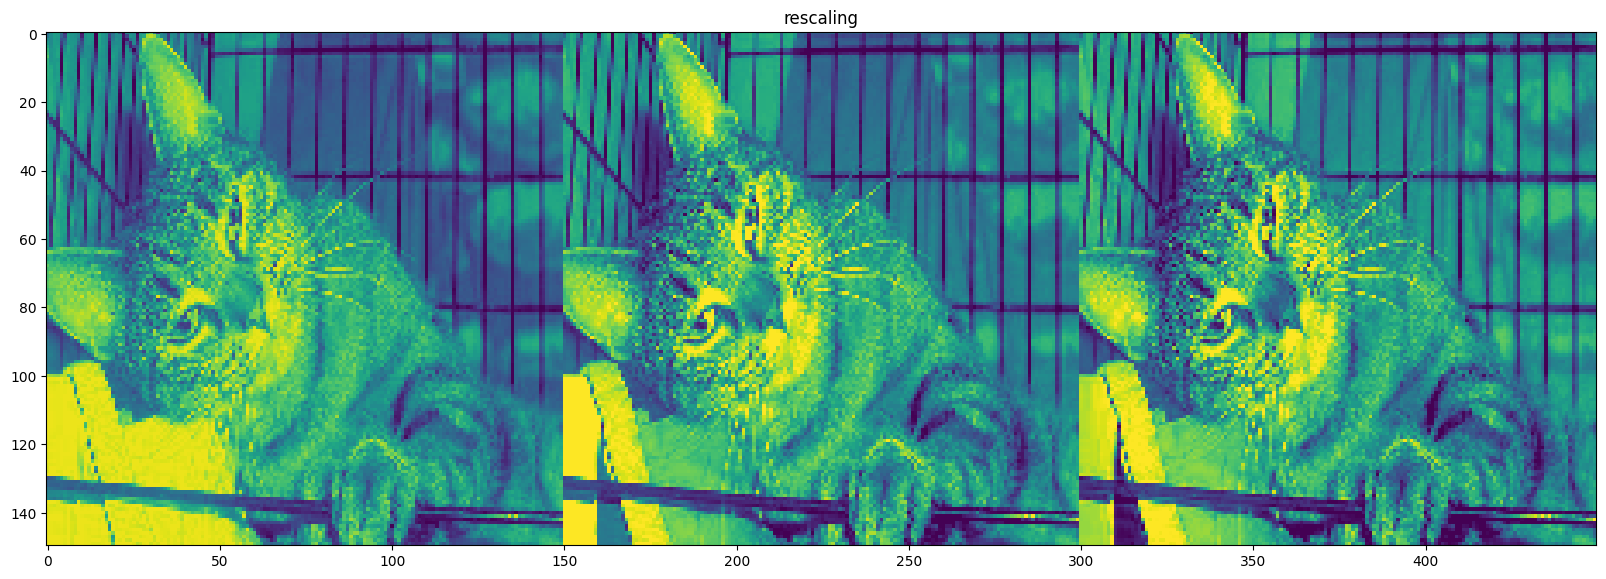

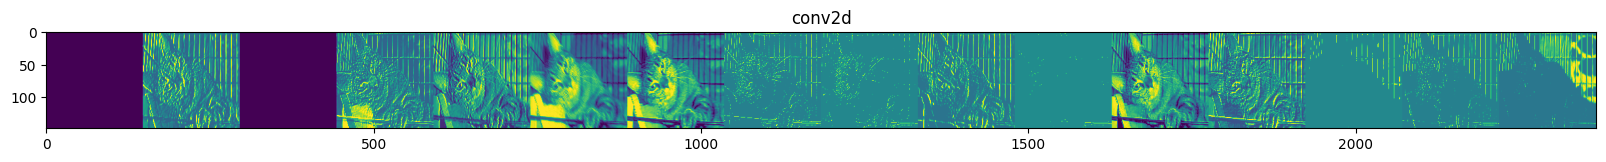

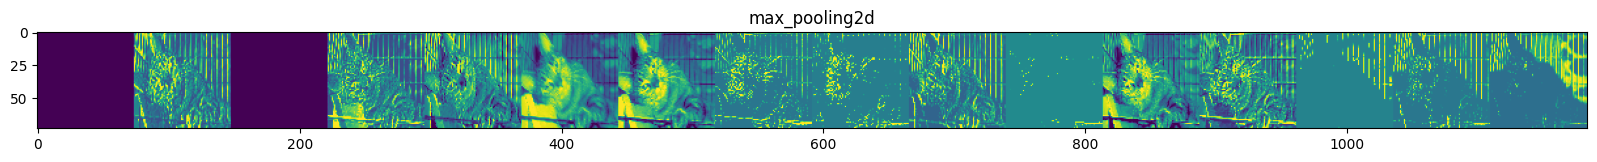

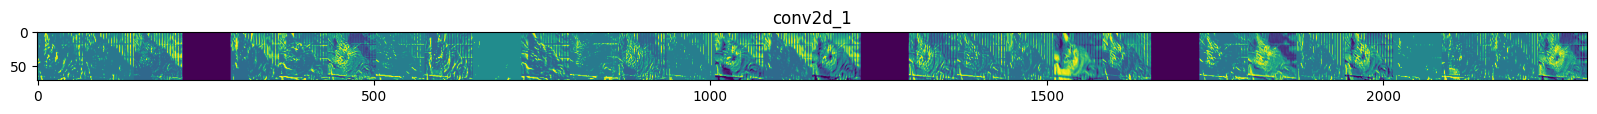

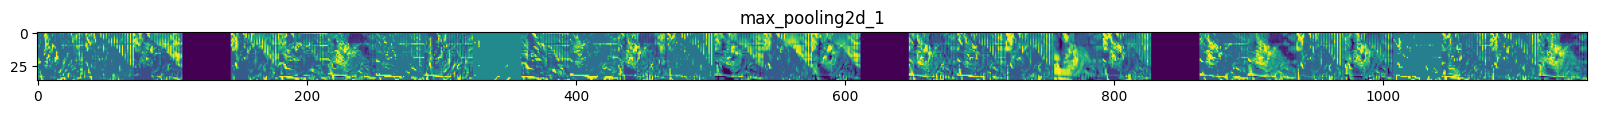

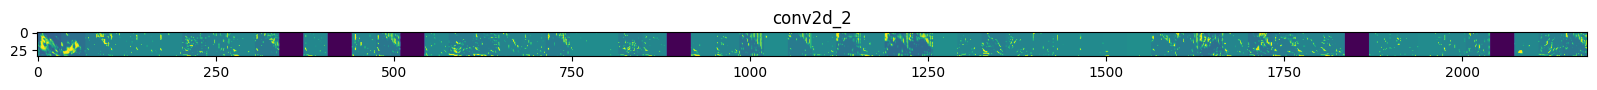

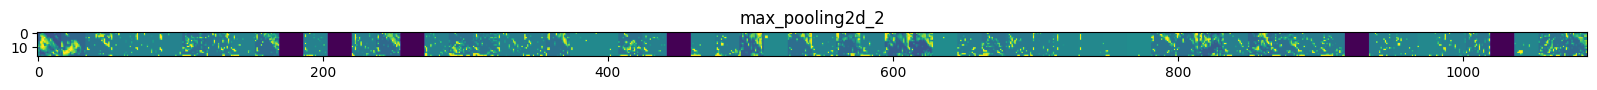

In [13]:
# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model
successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

# Prepare a random input image from the training set.
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = tf.keras.utils.load_img(img_path, target_size=(150, 150))  # this is a PIL image
x = tf.keras.utils.img_to_array(img) # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape) # Numpy array with shape (1, 150, 150, 3)

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    if len(feature_map.shape) == 4:

        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size = feature_map.shape[1]  # feature map shape (1, size, size, n_features)

        # Tile the images in this matrix
        display_grid = np.zeros((size, size * n_features))

        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid

        #-----------------
        # Display the grid
        #-----------------
        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

You can see above how the pixels highlighted turn to increasingly abstract and compact representations, especially at the bottom grid.

The representations downstream start highlighting what the network pays attention to, and they show fewer and fewer features being "activated"; most are set to zero. This is called _representation sparsity_ and is a key feature of deep learning. These representations carry increasingly less information about the original pixels of the image, but increasingly refined information about the class of the image. You can think of a CNN (or a deep network in general) as an information distillation pipeline wherein each layer filters out the most useful features.

### Evaluating Accuracy and Loss for the Model

You will plot the training/validation accuracy and loss as collected during training:

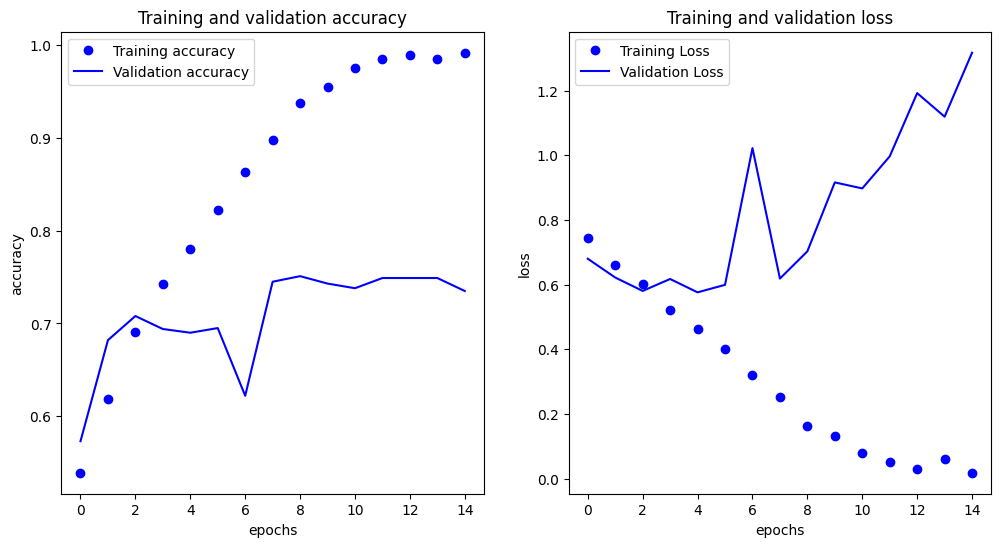

In [14]:
def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(acc))
    
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('accuracy')
    ax[0].legend()
    
    ax[1].plot(epochs, loss, 'bo', label='Training Loss')
    ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
    ax[1].set_title('Training and validation loss')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('loss')
    ax[1].legend()
    
    plt.show()

plot_loss_acc(history)

As you can see, the model is **overfitting** like it's getting out of fashion. The training accuracy (in blue) gets close to 100% while the validation accuracy (solid line) stalls at 70%. The validation loss reaches its minimum after only five epochs.

Since you have a relatively small number of training examples (2000), overfitting should be the number one concern. Overfitting happens when a model exposed to too few examples learns patterns that do not generalize to new data, i.e. when the model starts using irrelevant features for making predictions. For instance, if you, as a human, only see three images of people who are lumberjacks, and three images of people who are sailors, and among them the only person wearing a cap is a lumberjack, you might start thinking that wearing a cap is a sign of being a lumberjack as opposed to a sailor. You would then make a pretty lousy lumberjack/sailor classifier.

Overfitting is the central problem in machine learning: given that you are fitting the parameters of our model to a given dataset, how can you make sure that the representations learned by the model will be applicable to data it has never seen before? How do you avoid learning things that are specific to the training data?

In the next exercise, you'll look at ways to prevent overfitting in this classification model.